In [7]:
# library packages
import pickle
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense,Dropout, LSTM, Conv1D, Conv2D, GRU, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.applications.mobilenet import MobileNet

In [2]:
# load files
with open ('time_series_1.pickle','rb') as handle:
    time_series_1 = pickle.load(handle)
with open ('time_series_2.pickle','rb') as handle:
    time_series_2 = pickle.load(handle)
with open ('y.pickle','rb') as handle:
    y = pickle.load(handle)

In [3]:
# convert y to dummies with an array of (4000,4) 
b = pd.get_dummies(y)
y_dum = b.to_numpy()
y_dum.shape

# stack "time_series_1" and "time_series_2" data
series = np.dstack([time_series_1,time_series_2])

In [4]:
# splitting training, test and valid sets
X_train, X_other, y_train, y_other = train_test_split(series, y_dum, train_size=0.7, random_state = 657)
X_test, X_valid, y_test, y_valid = train_test_split(X_other, y_other, train_size = 0.5, random_state=391)

1. Create a recurrent neural network in TensorFlow to predict the operating mode of a
wind turbine based on the two time series from the sensors. Before any
implementation, carefully consider what type of approach (sequence-to-vector,
sequence-to-sequence, or encoder-decoder) is most sensible here and how you need to
manipulate the data, given that you have two different time series for each observation. 
Then, make sure that you try out the different layers and elements discussed in class,
such as SimpleRNN, LSTM and Conv1D - while a certain amount of trial and error will be
necessary, it is recommended that you tune your network systematically. Make sure to
record your final validation set accuracy.


In [6]:
### Convolutional 1D + GRU model ###
model_rnn = Sequential([
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",input_shape=[None, 2]),
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid"),
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid"),
    GRU(130),
    Dense(4,activation='softmax')])

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 20)          180       
                                                                 
 conv1d_1 (Conv1D)           (None, None, 20)          1620      
                                                                 
 conv1d_2 (Conv1D)           (None, None, 20)          1620      
                                                                 
 gru (GRU)                   (None, 130)               59280     
                                                                 
 dense (Dense)               (None, 4)                 524       
                                                                 
Total params: 63,224
Trainable params: 63,224
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Define train_plot_rnn for Convolutional 1D + GRU model 
def train_plot_rnn(model_rnn , learning_rate = 0.002, epochs = 20):
    np.random.seed(312)
    tf.random.set_seed(312)

    model_rnn.compile(loss="categorical_crossentropy",
                  optimizer=Adam(learning_rate = learning_rate),
                  metrics=["accuracy"])
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)
    log = model_rnn.fit(X_train, y_train, epochs=epochs,
                    batch_size=32,
                        validation_data=(X_valid, y_valid),
                   callbacks = [early_stopping_cb])
    
    plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
    plt.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    plt.legend()
    ax = plt.gca()
    ax.set_ylim([0, log.history['loss'][2]])
    plt.show()
    
    return model_rnn

Epoch 1/20
88/88 [==============================] - 22s 118ms/step - loss: 1.1133 - accuracy: 0.5121 - val_loss: 0.8018 - val_accuracy: 0.7200
Epoch 2/20
88/88 [==============================] - 10s 114ms/step - loss: 0.6495 - accuracy: 0.7650 - val_loss: 0.4741 - val_accuracy: 0.8417
Epoch 3/20
88/88 [==============================] - 10s 118ms/step - loss: 0.4398 - accuracy: 0.8314 - val_loss: 0.3407 - val_accuracy: 0.8750
Epoch 4/20
88/88 [==============================] - 10s 119ms/step - loss: 0.3350 - accuracy: 0.8729 - val_loss: 0.3398 - val_accuracy: 0.8800
Epoch 5/20
88/88 [==============================] - 10s 112ms/step - loss: 0.2989 - accuracy: 0.8796 - val_loss: 0.2829 - val_accuracy: 0.8950
Epoch 6/20
88/88 [==============================] - 10s 114ms/step - loss: 0.2589 - accuracy: 0.8925 - val_loss: 0.2631 - val_accuracy: 0.9067
Epoch 7/20
88/88 [==============================] - 10s 112ms/step - loss: 0.2479 - accuracy: 0.8950 - val_loss: 0.2802 - val_accuracy: 0.8867

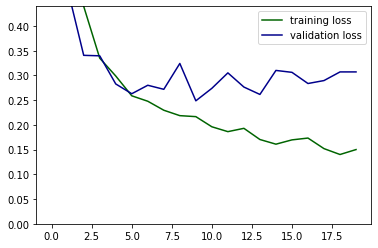

In [8]:
# Run train_plot_rnn of Convolutional 1D + GRU model 
train_plot_rnn(model_rnn)

In [16]:
# Evaluate Convolutional 1D + GRU model
test_score = model_rnn.evaluate(X_test,y_test,verbose=0)
valid_score = model_rnn.evaluate(X_valid,y_valid,verbose=0)

print('Test loss:', round(test_score[0],2))
print('Test accuracy:', round(test_score[1],2))
print('Valid loss:', round(valid_score[0],2))
print('Valid accuracy:', round(valid_score[1],2))

Test loss: 0.31
Test accuracy: 0.89
Valid loss: 0.25
Valid accuracy: 0.91


In [62]:
### GRU model  ###
model_gru = Sequential([
    GRU(100,return_sequences=True, input_shape=[None, 2]),
    GRU(100),
    Dense(50, activation='relu'),
    Dense(4,activation='softmax')
    ])
model_gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, None, 100)         31200     
                                                                 
 gru_2 (GRU)                 (None, 100)               60600     
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 4)                 204       
                                                                 
Total params: 97,054
Trainable params: 97,054
Non-trainable params: 0
_________________________________________________________________


In [63]:
# Define GRU train_plot_GRU
def train_plot_GRU(model_gru , learning_rate = 0.001, epochs = 20):
    np.random.seed(312)
    tf.random.set_seed(312)

    model_gru.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate = learning_rate),
                  metrics=["accuracy"])
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)
    log = model_gru.fit(X_train, y_train, epochs=epochs,
                    batch_size=32,
                        validation_data=(X_valid, y_valid),
                   callbacks = [early_stopping_cb])
    
    plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
    plt.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    plt.legend()
    ax = plt.gca()
    ax.set_ylim([0, log.history['loss'][2]])
    plt.show()
    
    return model_gru

Epoch 1/20
88/88 [==============================] - 106s 1s/step - loss: 1.3806 - accuracy: 0.2889 - val_loss: 1.3146 - val_accuracy: 0.3483
Epoch 2/20
88/88 [==============================] - 101s 1s/step - loss: 1.2242 - accuracy: 0.4532 - val_loss: 1.0846 - val_accuracy: 0.5450
Epoch 3/20
88/88 [==============================] - 101s 1s/step - loss: 1.0410 - accuracy: 0.5350 - val_loss: 0.9581 - val_accuracy: 0.6150
Epoch 4/20
88/88 [==============================] - 101s 1s/step - loss: 0.8846 - accuracy: 0.6211 - val_loss: 0.7973 - val_accuracy: 0.6750
Epoch 5/20
88/88 [==============================] - 101s 1s/step - loss: 0.7768 - accuracy: 0.6718 - val_loss: 0.6861 - val_accuracy: 0.7350
Epoch 6/20
88/88 [==============================] - 101s 1s/step - loss: 0.6794 - accuracy: 0.7179 - val_loss: 0.6680 - val_accuracy: 0.7417
Epoch 7/20
88/88 [==============================] - 102s 1s/step - loss: 0.6256 - accuracy: 0.7361 - val_loss: 0.5262 - val_accuracy: 0.8017
Epoch 8/20
88

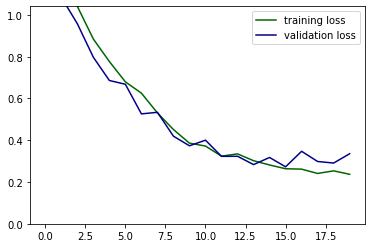

In [64]:
# Run train_plot_GRU
train_plot_GRU(model_gru)

In [65]:
# Evaluate GRU model 
test_score = model_gru.evaluate(X_test,y_test,verbose=0)
valid_score = model_gru.evaluate(X_valid,y_valid,verbose=0)

print('Test loss:', round(test_score[0],2))
print('Test accuracy:', round(test_score[1],2))
print('Valid loss:', round(valid_score[0],2))
print('Valid accuracy:', round(valid_score[1],2))

Test loss: 0.37
Test accuracy: 0.86
Valid loss: 0.34
Valid accuracy: 0.88


In [6]:
### LSTM model ###
model_lstm = Sequential([
    LSTM(50,return_sequences=True, input_shape=[None, 2]),
    LSTM(50),
    Dense(4,activation='softmax')
    ])
model_lstm.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 50)          10600     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 4)                 204       
                                                                 
Total params: 31,004
Trainable params: 31,004
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Define LSTM train_plot
def train_plot_LSTM(model_lstm , learning_rate = 0.001, epochs = 20):
    np.random.seed(312)
    tf.random.set_seed(312)

    model_lstm.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate = learning_rate),
                  metrics=["accuracy"])
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)
    log = model_lstm.fit(X_train, y_train, epochs=epochs,
                    batch_size=25,
                    validation_data=(X_valid, y_valid),
                    callbacks = [early_stopping_cb])
    
    plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
    plt.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    plt.legend()
    ax = plt.gca()
    ax.set_ylim([0, log.history['loss'][2]])
    plt.show()
    
    return model_lstm

Epoch 1/20
112/112 [==============================] - 164s 1s/step - loss: 1.3876 - accuracy: 0.2636 - val_loss: 1.3750 - val_accuracy: 0.2417
Epoch 2/20
112/112 [==============================] - 157s 1s/step - loss: 1.3499 - accuracy: 0.3275 - val_loss: 1.3241 - val_accuracy: 0.3833
Epoch 3/20
112/112 [==============================] - 157s 1s/step - loss: 1.3231 - accuracy: 0.3625 - val_loss: 1.3127 - val_accuracy: 0.4167
Epoch 4/20
112/112 [==============================] - 157s 1s/step - loss: 1.2703 - accuracy: 0.4329 - val_loss: 1.2041 - val_accuracy: 0.4750
Epoch 5/20
112/112 [==============================] - 157s 1s/step - loss: 1.1850 - accuracy: 0.4800 - val_loss: 1.1608 - val_accuracy: 0.4767
Epoch 6/20
112/112 [==============================] - 157s 1s/step - loss: 1.0821 - accuracy: 0.5164 - val_loss: 1.0676 - val_accuracy: 0.5117
Epoch 7/20
112/112 [==============================] - 157s 1s/step - loss: 0.9885 - accuracy: 0.5771 - val_loss: 0.9306 - val_accuracy: 0.5950

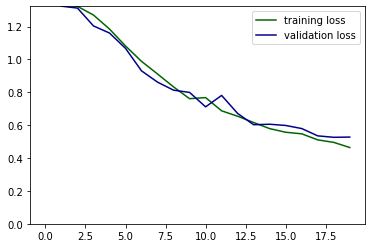

In [8]:
# Run train_plot_LSTM
train_plot_LSTM(model_lstm)

In [9]:
# Evaluate on LSTM model
test_score = model_lstm.evaluate(X_test,y_test,verbose=0)
valid_score = model_lstm.evaluate(X_valid,y_valid,verbose=0)

print('Test loss:', round(test_score[0],2))
print('Test accuracy:', round(test_score[1],2))
print('Valid loss:', round(valid_score[0],2))
print('Valid accuracy:', round(valid_score[1],2))

Test loss: 0.57
Test accuracy: 0.78
Valid loss: 0.53
Valid accuracy: 0.8


The first model consists of a 1D convolutional neural network (CNN) with three convolutional layers and a layer of GRU. The model achieved an accuracy score of 0.91 and a loss of 0.25. The second model consists of two GRU layers and achived an accuracy score of 0.88 and a loss of 0.34. The third model consists of two layers of LSTM and achieved an accuracy score of 0.80 and a loss of 0.53. 

Overall, 1D CNN with a layer of GRU showed a better performance than the RNN models in predicting the operating mode of a wind turbine based on the two time-series from the sensor. 

2. Another tool for analyzing time-series data is convolutional neural networks with 2D convolutional layers. For this to work, time series need to be converted into “images” (matrices of numbers). The paper “Convolutional neural network fault classification based on time series analysis for benchmark wind turbine machine” by Rahimilarki, Gao, Jin, and Zhang (published 2022 in “Renewable Energy” and available through the City-library) describes how two-dimensional CNNs can be applied to the problem at hand. Consider sections 4 and 5 that depict the process of converting one or multiple time series into “images” used within a CNN.In your own words, explain why the approach outlined here can help analyze time-series data and why it might outperform RNNs.

The main challenge of time-series data is the high volatility of the signals due to noises in the time-series data. CNN addresses these challenges by classifying data from the benchmark consisting of even the slightest anomalies and signal noises. In wind turbines, CNN can be applied in both onshore and offshore machines to tackle more dynamics and environmental disturbances. The time-series data structure is 2-Dimensional, the same as 2-Dimensional images (grey-scale), and thus CNN can convert the raw signals into 2D images. CNN fills the image matrix row by row with the time-series data. The information can then be obtained from the image by analysing the association between adjacent pixels. 

Moreover, CNN is computationally cheaper than RNN as CNN models learn patterns by batch, allowing parallelised training. In contrast, RNN models train data in sequence, which requires completing the previous computations before proceeding to the next. Another advantage of CNN is that it considers the "spatial" structure of the data, unlike RNN, which takes information before the timestep of the prediction.

3.  Convert the data for use with a CNN. In particular, following the approach outlined in
Scenario 2 (section 5.3 of the paper) and summarized in Figure 18, convert the two time
series corresponding to one wind turbine run into a single (100,100,1) array (i.e., a grayscale image).

In [5]:
## convert time-series to grey-scale image
num_classes = 4
img_rows, img_cols, img_channels = 100, 100, 1 # input image dimensions

# Load and convert data
x_train = X_train.astype('float32')
x_test = X_test.astype('float32')
x_valid = X_valid.astype('float32')

# Depending on the implementation, the underlying libraries might want the image 
# dimensions in different orders, check for it and reshape
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], img_channels, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], img_channels, img_rows, img_cols)
    x_valid = x_valid.reshape(x_valid.shape[0], img_channels, img_rows, img_cols)
    input_shape = (img_channels, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, img_channels)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, img_channels)
    x_valid = x_valid.reshape(x_valid.shape[0], img_rows, img_cols, img_channels)
    input_shape = (img_rows, img_cols, img_channels)

print('x_train shape:', x_train.shape)
print('y_train:', y_train.shape)


x_train shape: (2800, 100, 100, 1)
y_train: (2800, 4)


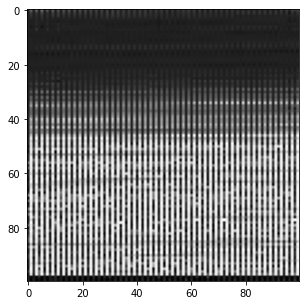

In [6]:
plt.figure(figsize=(5, 5))
plt.imshow(x_train[0].astype(int),cmap="Greys_r")
plt.show()

4. In TensorFlow, replicate the CNN with two convolutional layers displayed in Figure 12
and train it on your data. Make sure to record your final validation set accuracy.

In [12]:
### CNN model according to Figure 12 of the literature
model_cnn1 = Sequential([
    Conv2D(32, kernel_size=(3, 3),strides=(2,2),padding='same',input_shape=input_shape),
    Conv2D(32, kernel_size=(3, 3),strides=(2,2),padding='same'),
    Dropout(0.2),
    Conv2D(16, kernel_size=(3, 3),strides=(2,2),padding='same',activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Flatten(),
    Dense(num_classes, activation='softmax')
    ])
model_cnn1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 32)        9248      
                                                                 
 dropout (Dropout)           (None, 25, 25, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 16)        4624      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 16)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                      

In [13]:
# CNN model (according to Figure 12) train_plot
def train_plot_cnn1(model_cnn1 , learning_rate = 0.002, epochs = 20):
    np.random.seed(312)
    tf.random.set_seed(312)

    model_cnn1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)
    log = model_cnn1.fit(x_train, y_train, epochs=epochs,
                    batch_size=32,
                    validation_data=(x_valid, y_valid),
                   callbacks = [early_stopping_cb])
    
    plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
    plt.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    plt.legend()
    ax = plt.gca()
    ax.set_ylim([0, log.history['loss'][2]])
    plt.show()
    
    return model_cnn1

Epoch 1/20
88/88 [==============================] - 8s 17ms/step - loss: 7.1261 - accuracy: 0.3436 - val_loss: 0.8097 - val_accuracy: 0.6617
Epoch 2/20
88/88 [==============================] - 1s 13ms/step - loss: 1.4185 - accuracy: 0.5996 - val_loss: 0.4013 - val_accuracy: 0.8233
Epoch 3/20
88/88 [==============================] - 1s 13ms/step - loss: 0.9303 - accuracy: 0.7207 - val_loss: 0.2987 - val_accuracy: 0.9150
Epoch 4/20
88/88 [==============================] - 1s 14ms/step - loss: 0.7188 - accuracy: 0.7914 - val_loss: 0.2560 - val_accuracy: 0.8817
Epoch 5/20
88/88 [==============================] - 1s 15ms/step - loss: 0.6282 - accuracy: 0.8082 - val_loss: 0.2533 - val_accuracy: 0.8933
Epoch 6/20
88/88 [==============================] - 1s 12ms/step - loss: 0.5392 - accuracy: 0.8271 - val_loss: 0.2461 - val_accuracy: 0.9033
Epoch 7/20
88/88 [==============================] - 1s 13ms/step - loss: 0.4946 - accuracy: 0.8361 - val_loss: 0.4213 - val_accuracy: 0.9067
Epoch 8/20
88

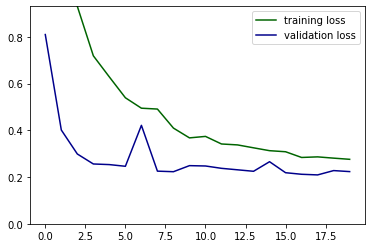

In [14]:
# Run train_plot_cnn1
train_plot_cnn1(model_cnn1)

In [15]:
# Evaluate CNN model 
test_score = model_cnn1.evaluate(x_test,y_test,verbose=0)
valid_score = model_cnn1.evaluate(x_valid,y_valid,verbose=0)

print('Test loss:', round(test_score[0],2))
print('Test accuracy:', round(test_score[1],2))
print('Valid loss:', round(valid_score[0],2))
print('Valid accuracy:', round(valid_score[1],2))

Test loss: 0.23
Test accuracy: 0.9
Valid loss: 0.22
Valid accuracy: 0.92


5. Can you do better by adjusting the CNN? Be creative in your design choices (you might
also consider pre-trained CNN architectures) and record your final validation set
accuracy.

In [16]:
### CNN model consisting of 4 convolutional layers and a dense layer 
num_classes = 4
model_cnn2 = Sequential([
    Conv2D(128, kernel_size=(3, 3),strides=(2,2),padding='same',input_shape=input_shape),
    Conv2D(64, kernel_size=(3, 3),strides=(2,2),padding='same'),
    Dropout(0.2),
    Conv2D(32, kernel_size=(3, 3),strides=(2,2),padding='same',activation='relu'),
    Conv2D(16, kernel_size=(3, 3),strides=(2,2),padding='same',activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Flatten(),
    Dense(num_classes, activation='softmax')
    ])
model_cnn2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       1280      
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 64)        73792     
                                                                 
 dropout_1 (Dropout)         (None, 25, 25, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 32)        18464     
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 16)          4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 16)         0         
 2D)                                                             
                                                      

In [17]:
# train_plot of CNN model with 4 convolutional layer
def train_plot_cnn2(model_cnn2 , learning_rate = 0.002, epochs = 20):
    np.random.seed(312)
    tf.random.set_seed(312)

    model_cnn2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy'])
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)  
    log = model_cnn2.fit(x_train, y_train, epochs=epochs,
                    batch_size=20,
                    validation_data=(x_valid, y_valid),
                    callbacks = [early_stopping_cb])
    
    plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
    plt.plot(log.history['val_loss'],label = "validation loss",color='darkblue')
    plt.legend()
    ax = plt.gca()
    ax.set_ylim([0, log.history['loss'][2]])
    plt.show()
    
    return model_cnn2

Epoch 1/20
140/140 [==============================] - 4s 23ms/step - loss: 4.3324 - accuracy: 0.4350 - val_loss: 0.4673 - val_accuracy: 0.8783
Epoch 2/20
140/140 [==============================] - 3s 22ms/step - loss: 0.4612 - accuracy: 0.8300 - val_loss: 0.2351 - val_accuracy: 0.9200
Epoch 3/20
140/140 [==============================] - 3s 22ms/step - loss: 0.3863 - accuracy: 0.8529 - val_loss: 0.2488 - val_accuracy: 0.9217
Epoch 4/20
140/140 [==============================] - 3s 22ms/step - loss: 0.3625 - accuracy: 0.8664 - val_loss: 0.2381 - val_accuracy: 0.9067
Epoch 5/20
140/140 [==============================] - 3s 22ms/step - loss: 0.3703 - accuracy: 0.8596 - val_loss: 0.2332 - val_accuracy: 0.9167
Epoch 6/20
140/140 [==============================] - 3s 22ms/step - loss: 0.3215 - accuracy: 0.8661 - val_loss: 0.3115 - val_accuracy: 0.8117
Epoch 7/20
140/140 [==============================] - 3s 22ms/step - loss: 0.3262 - accuracy: 0.8700 - val_loss: 0.2520 - val_accuracy: 0.9183

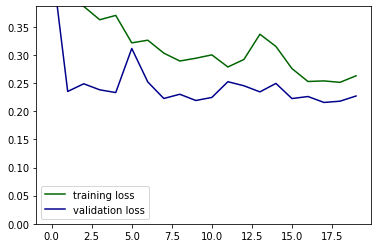

In [18]:
# Run train_plot_cnn2
train_plot_cnn2(model_cnn2)

In [19]:
# Evaluation of model_cnn2
test_score = model_cnn2.evaluate(x_test,y_test,verbose=0)
valid_score = model_cnn2.evaluate(x_valid,y_valid,verbose=0)

print('Test loss:', round(test_score[0],2))
print('Test accuracy:', round(test_score[1],2))
print('Valid loss:', round(valid_score[0],2))
print('Valid accuracy:', round(valid_score[1],2))

Test loss: 0.25
Test accuracy: 0.89
Valid loss: 0.23
Valid accuracy: 0.91


In [20]:
### Pre-trained CNN model: MobileNet ###
mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape = (100,100,3))
mobilenet.trainable = False
# Freeze layers in the base model except the last two
for layer in mobilenet.layers[:60]:
    layer.trainable = True

model_mobilenet = Sequential([
    Conv2D(3, kernel_size=(3, 3),strides=(1,1),padding='same',input_shape=input_shape),
    mobilenet,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')])

model_mobilenet.summary()


17235968/17225924 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 100, 100, 3)       30        
                                                                 
 mobilenet_1.00_224 (Functio  (None, 3, 3, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_3 (Dense)             (None, 64)                65600     
                                                                 
 dense_4 (Dense)             (None, 4)                 260       
                                                       

In [21]:
def train_plot_mobilenet(model_mobilenet , learning_rate = 0.0001, epochs = 20):
    np.random.seed(312)
    tf.random.set_seed(312)

    model_mobilenet.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy'])
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights=True)
    log = model_mobilenet.fit(x_train, y_train, epochs=epochs,
                    batch_size=20,
                    validation_data=(x_valid, y_valid),
                    callbacks = [early_stopping_cb])
    
    plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
    plt.plot(log.history['val_loss'],label = "validation loss",color='darkblue')
    plt.legend()
    ax = plt.gca()
    ax.set_ylim([0, log.history['loss'][2]])
    plt.show()
    
    return model_mobilenet

Epoch 1/20
140/140 [==============================] - 10s 54ms/step - loss: 1.2766 - accuracy: 0.4500 - val_loss: 1.9737 - val_accuracy: 0.2650
Epoch 2/20
140/140 [==============================] - 7s 49ms/step - loss: 0.8031 - accuracy: 0.6821 - val_loss: 0.9691 - val_accuracy: 0.6300
Epoch 3/20
140/140 [==============================] - 7s 49ms/step - loss: 0.6090 - accuracy: 0.7800 - val_loss: 0.5510 - val_accuracy: 0.8250
Epoch 4/20
140/140 [==============================] - 7s 48ms/step - loss: 0.5000 - accuracy: 0.8189 - val_loss: 0.4338 - val_accuracy: 0.8650
Epoch 5/20
140/140 [==============================] - 7s 49ms/step - loss: 0.4361 - accuracy: 0.8454 - val_loss: 0.3894 - val_accuracy: 0.8783
Epoch 6/20
140/140 [==============================] - 7s 47ms/step - loss: 0.3879 - accuracy: 0.8679 - val_loss: 0.3712 - val_accuracy: 0.8683
Epoch 7/20
140/140 [==============================] - 7s 47ms/step - loss: 0.3615 - accuracy: 0.8679 - val_loss: 0.3304 - val_accuracy: 0.885

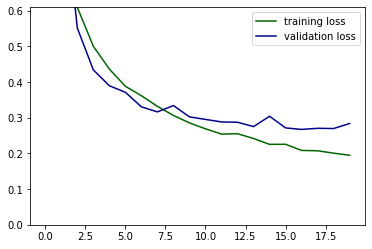

In [22]:
# Run train_plot_mobilenet
train_plot_mobilenet(model_mobilenet)

In [23]:
# Evaluate the mobilenet model 
test_score = model_mobilenet.evaluate(x_test,y_test,verbose=0)
valid_score = model_mobilenet.evaluate(x_valid,y_valid,verbose=0)

print('Test loss:', round(test_score[0],2))
print('Test accuracy:', round(test_score[1],2))
print('Valid loss:', round(valid_score[0],2))
print('Valid accuracy:', round(valid_score[1],2))

Test loss: 0.31
Test accuracy: 0.85
Valid loss: 0.28
Valid accuracy: 0.87


The CNN with three convolutional layers and the CNN with four layers showed very similar score with an accuracy of 0.92 and 0.91 and a loss of 0.22 and 0.23, respectively. The pre-trained model, Mobilenet, with a convolutional layer, showed a lower accuracy score of 0.87 and a higher loss of 0.28, performing worse in the prediction than the previous models. 

6. Compare the models you have created so far (both RNNs and CNNs) and make a
selection (making sure to justify this). Train that model on a combined training and
validation set and evaluate it on your test set.

In [24]:
# 85% training set and 15 % test set
# splitting training and test sets
X_train, X_test, y_train, y_test = train_test_split(series, y_dum, train_size=0.85, random_state = 657)

In [25]:
## convert time-series to grey-scale image
num_classes = 4
img_rows, img_cols, img_channels = 100, 100, 1 # input image dimensions

# Load and convert data
x_train = X_train.astype('float32')
x_test = X_test.astype('float32')

# Depending on the implementation, the underlying libraries might want the image 
# dimensions in different orders, check for it and reshape
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], img_channels, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], img_channels, img_rows, img_cols)
    input_shape = (img_channels, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, img_channels)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, img_channels)
    input_shape = (img_rows, img_cols, img_channels)

print('x_train shape:', x_train.shape)
print('y_train:', y_train.shape)

x_train shape: (3400, 100, 100, 1)
y_train: (3400, 4)


In [26]:
### CNN model according to Figure 12 of the literature ###
best_model = Sequential([
    Conv2D(32, kernel_size=(3, 3),strides=(2,2),padding='same',input_shape=input_shape),
    Conv2D(32, kernel_size=(3, 3),strides=(2,2),padding='same'),
    Dropout(0.2),
    Conv2D(16, kernel_size=(3, 3),strides=(2,2),padding='same',activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Flatten(),
    Dense(num_classes, activation='softmax')
    ])
best_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 50, 50, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 25, 25, 32)        9248      
                                                                 
 dropout_2 (Dropout)         (None, 25, 25, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 256)               0         
                                                      

In [27]:
# CNN model (according to Figure 12) train_plot
def train_plot_best(best_model , learning_rate = 0.001, epochs = 20):
    np.random.seed(312)
    tf.random.set_seed(312)

    best_model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              metrics=['accuracy'])
    log = best_model.fit(x_train, y_train, epochs=epochs,
                    batch_size=32)
    
    plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
    plt.legend()
    ax = plt.gca()
    ax.set_ylim([0, log.history['loss'][2]])
    plt.show()
    
    return best_model

Epoch 1/20
107/107 [==============================] - 2s 12ms/step - loss: 5.9651 - accuracy: 0.3676
Epoch 2/20
107/107 [==============================] - 1s 11ms/step - loss: 1.2247 - accuracy: 0.6612
Epoch 3/20
107/107 [==============================] - 1s 11ms/step - loss: 0.7483 - accuracy: 0.7744
Epoch 4/20
107/107 [==============================] - 1s 11ms/step - loss: 0.6095 - accuracy: 0.8174
Epoch 5/20
107/107 [==============================] - 1s 11ms/step - loss: 0.5424 - accuracy: 0.8365
Epoch 6/20
107/107 [==============================] - 1s 11ms/step - loss: 0.4481 - accuracy: 0.8471
Epoch 7/20
107/107 [==============================] - 1s 11ms/step - loss: 0.4320 - accuracy: 0.8459
Epoch 8/20
107/107 [==============================] - 1s 11ms/step - loss: 0.3707 - accuracy: 0.8635
Epoch 9/20
107/107 [==============================] - 1s 11ms/step - loss: 0.3634 - accuracy: 0.8550
Epoch 10/20
107/107 [==============================] - 1s 11ms/step - loss: 0.3553 - accura

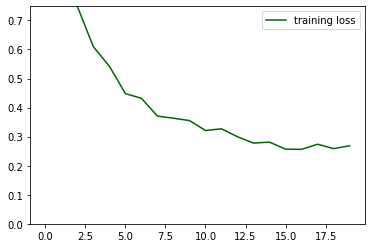

In [28]:
# Run best model 
train_plot_best(best_model)

In [29]:
# Evaluate best model
test_score = best_model.evaluate(x_test,y_test,verbose=0)

print('Test loss:', round(test_score[0],2))
print('Test accuracy:', round(test_score[1],2))

Test loss: 0.23
Test accuracy: 0.91


In [35]:
#save it as h5 file
best_model.save("best_model.h5")

Overall, CNN models have demonstrated better performance than RNN models in predicting the operating mode of a wind turbine. The loss for CNN models is generally lower than for RNN models, including GRU and LTSM models. Similarly, the accuracy of 1D CNN with a GRU layer and the other CNN models are also generally higher than the accuracy of the GRU and LTSM models. 

Among the CNN models, both models with three 2D convolutional and four convolutional layers showed the best accuracies. Nevertheless, the final best performing model chosen was the 2D CNN with three convolutional layers due to its higher accuracy and lower loss. The model was trained on the combined validation sets, giving an test accuracy score of 0.91 and a loss of 0.23. 